In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.feature_extraction import FeatureHasher
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import joblib


# import data

In [2]:
# Load data
df= pd.read_csv('onlinefoods.csv')

# Display first few rows
df.head()


,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output,Feedback,Unnamed: 12
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes,Positive,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes,Positive,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes,Negative,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes,Positive,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes,Positive,Yes


# Exploratory Data Analysis

In [3]:
print(df.dtypes)

Age                             int64
Gender                         object
Marital Status                 object
Occupation                     object
Monthly Income                 object
Educational Qualifications     object
Family size                     int64
latitude                      float64
longitude                     float64
Pin code                        int64
Output                         object
Feedback                       object
Unnamed: 12                    object
dtype: object


In [4]:
# delete Unnamed values because Output=Unnamed: 12
df= df.drop('Unnamed: 12', axis=1)

# Checking for missing values
print(df.isnull().sum())

Age                           0
Gender                        0
Marital Status                0
Occupation                    0
Monthly Income                0
Educational Qualifications    0
Family size                   0
latitude                      0
longitude                     0
Pin code                      0
Output                        0
Feedback                      0
dtype: int64


In [5]:
# Descriptive statistics
print(df[['Age', 'Family size']].describe())


              Age  Family size
count  388.000000   388.000000
mean    24.628866     3.280928
std      2.975593     1.351025
min     18.000000     1.000000
25%     23.000000     2.000000
50%     24.000000     3.000000
75%     26.000000     4.000000
max     33.000000     6.000000


# Visualization

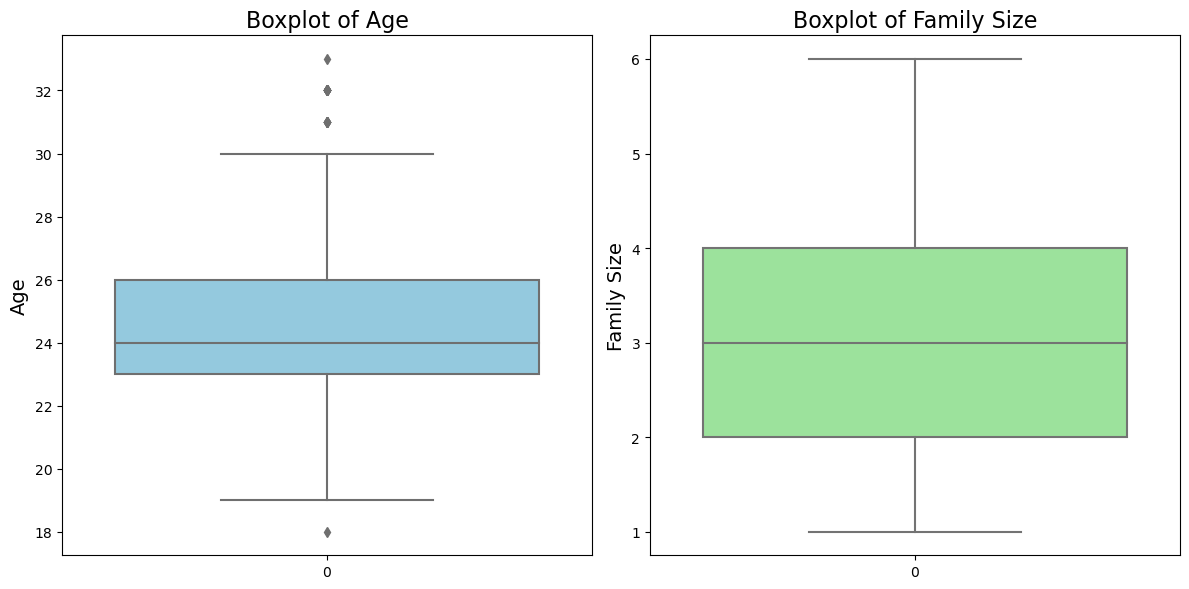

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengatur ukuran gambar
plt.figure(figsize=(12, 6))

# Boxplot 'Age'
plt.subplot(1, 2, 1)
sns.boxplot(data=df['Age'], color='skyblue')
plt.title('Boxplot of Age', fontsize=16)
plt.ylabel('Age', fontsize=14)

# Boxplot 'Family size'
plt.subplot(1, 2, 2)
sns.boxplot(data=df['Family size'], color='lightgreen')
plt.title('Boxplot of Family Size', fontsize=16)
plt.ylabel('Family Size', fontsize=14)

# Menampilkan plot
plt.tight_layout()
plt.show()


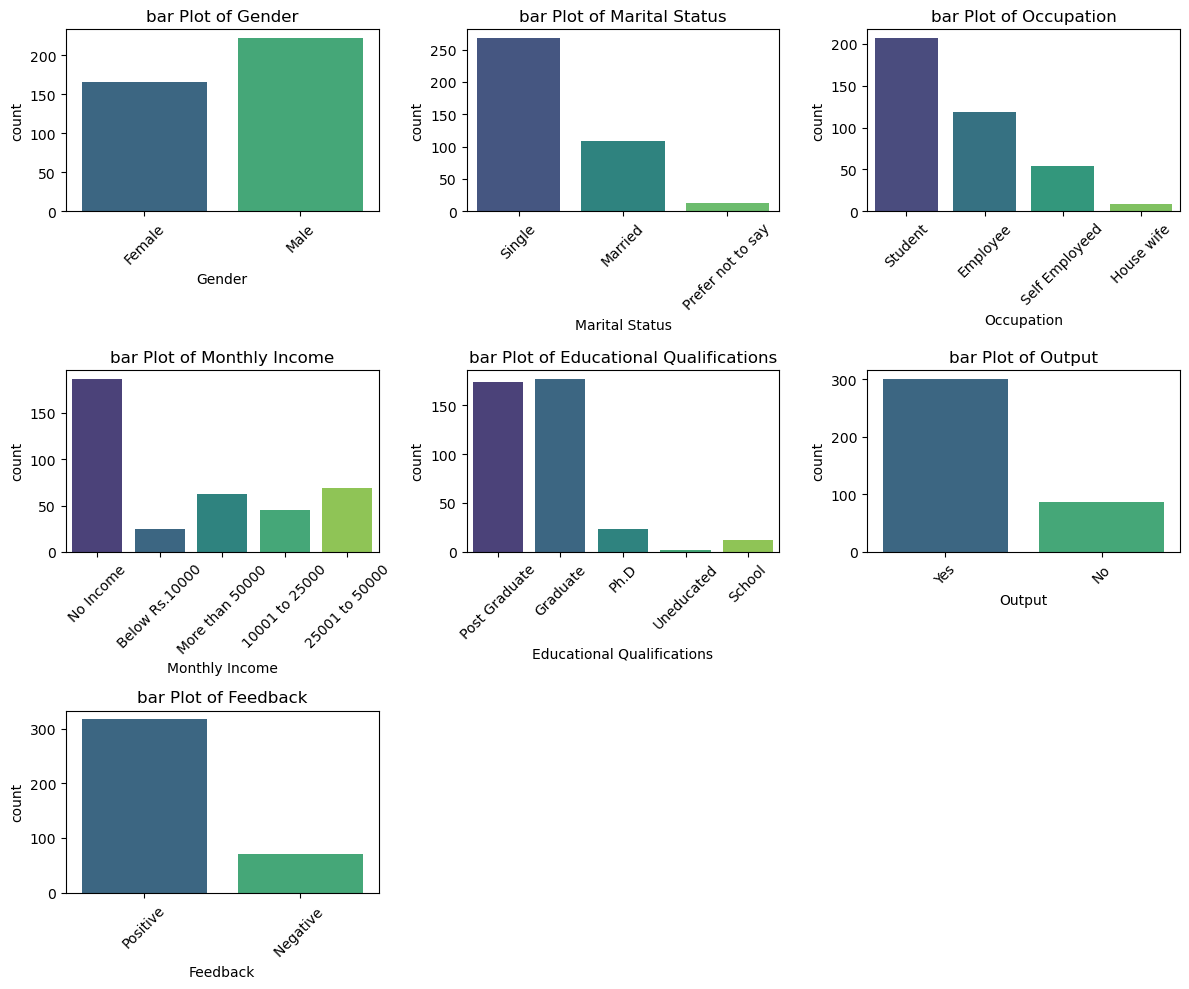

In [7]:
plt.figure(figsize=(12, 10))

for i, column in enumerate(['Gender', 'Marital Status', 'Occupation', 'Monthly Income','Educational Qualifications', 'Output','Feedback'], 1):
    plt.subplot(3, 3, i)
    sns.countplot(data=df, x=column, palette='viridis')
    plt.xticks(rotation=45)
    plt.title(f'bar Plot of {column}')

plt.tight_layout()
plt.show()


# Data Preprocessing (handling missing values, encoding categorical variables, and scaling numerical features. )

In [8]:
#Fill missing values with mean for numerical columns
#df.fillna(df.mean(), inplace=True)

#For categorical columns, fill missing values with mode
#categorical_cols = df.select_dtypes(include=['object']).columns
#for col in categorical_cols:
 #   df[col].fillna(df[col].mode()[0], inplace=True)
    #  there are no missing values, so there is no need to fill it in.  

In [9]:
categorical_features = ['Gender', 'Marital Status', 'Occupation', 'Monthly Income','Educational Qualifications','Feedback']
numerical_features = ['Age', 'Family size','latitude','longitude','Pin code']


In [10]:
ct = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)
ct

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', MinMaxScaler(),
                                 ['Age', 'Family size', 'latitude', 'longitude',
                                  'Pin code']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['Gender', 'Marital Status', 'Occupation',
                                  'Monthly Income',
                                  'Educational Qualifications', 'Feedback'])])

In [11]:
# Separate features and target
x = df.drop('Output', axis=1)
y = df['Output']

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

# Apply transformations
X_train_transformed = ct.fit_transform(x_train)
X_test_transformed = ct.transform(x_test)

# Model Training and Comparison

In [12]:
# Define the models
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('Random Forest', RandomForestClassifier())) 
models.append(('SVM', SVC(gamma='auto')))

# Evaluate each model
results = []
names = []
accuracy_results = []
precision_results = []
recall_results = []
f1_results = []

for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train_transformed, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name} Accuracy: {cv_results.mean():.6f} ({cv_results.std():.6f})')
    
    # Train the model on the full training set
    model.fit(X_train_transformed, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test_transformed)
    
    # Evaluate using other metrics
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Store metrics
    accuracy_results.append(accuracy_score(y_test, y_pred))
    precision_results.append(precision)
    recall_results.append(recall)
    f1_results.append(f1)
    
    print(f'{name} - Precision: {precision:.6f}, Recall: {recall:.6f}, F1 Score: {f1:.6f}')


KNN Accuracy: 0.845161 (0.045161)
KNN - Precision: 0.890499, Recall: 0.897436, F1 Score: 0.889643
Random Forest Accuracy: 0.893548 (0.062965)
Random Forest - Precision: 0.892356, Recall: 0.897436, F1 Score: 0.893939
SVM Accuracy: 0.870968 (0.053978)
SVM - Precision: 0.846154, Recall: 0.846154, F1 Score: 0.846154


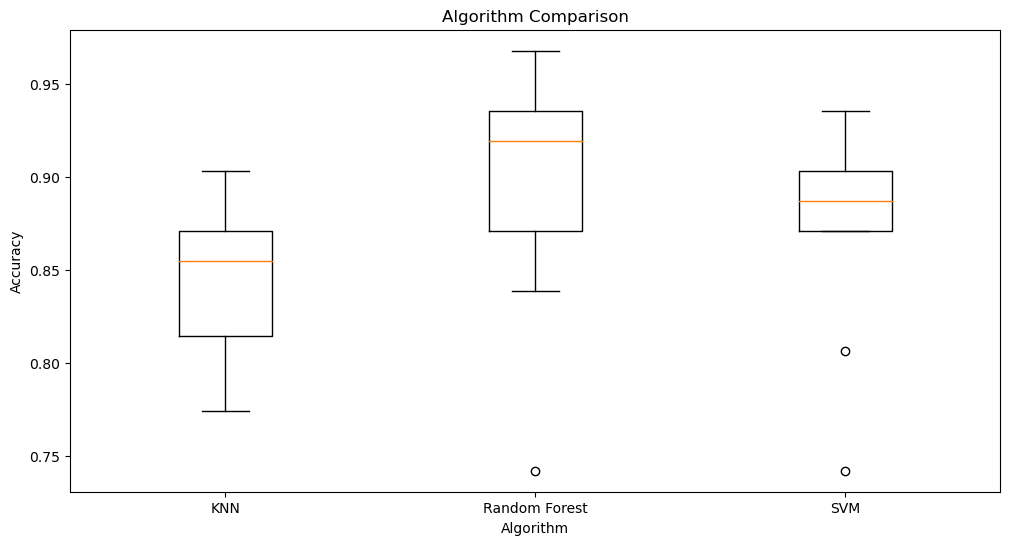

In [13]:
# Plot the model performance
plt.figure(figsize=(12, 6))
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.xlabel('Algorithm')
plt.ylabel('Accuracy')
plt.show()

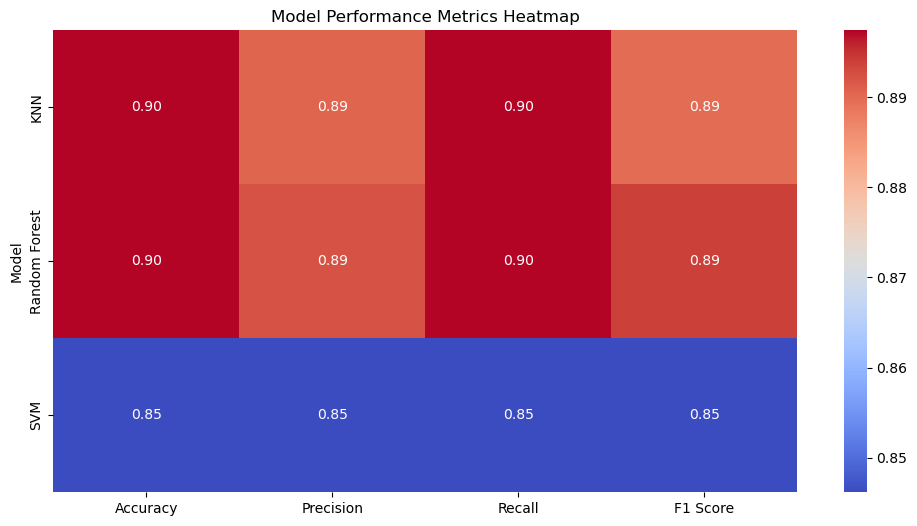

In [14]:
# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Model': names,
    'Accuracy': accuracy_results,
    'Precision': precision_results,
    'Recall': recall_results,
    'F1 Score': f1_results
})

# Set the model as the index
metrics_df.set_index('Model', inplace=True)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Model Performance Metrics Heatmap')
plt.show()


In [15]:
# Evaluate each model using cross-validation
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train_transformed, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    
    # Print the mean and standard deviation of accuracy
    print(f'{name}', confusion_matrix(y_test, y_pred))
    print(f'{name}', classification_report(y_test, y_pred))


KNN [[ 7  6]
 [ 6 59]]
KNN               precision    recall  f1-score   support

          No       0.54      0.54      0.54        13
         Yes       0.91      0.91      0.91        65

    accuracy                           0.85        78
   macro avg       0.72      0.72      0.72        78
weighted avg       0.85      0.85      0.85        78

Random Forest [[ 7  6]
 [ 6 59]]
Random Forest               precision    recall  f1-score   support

          No       0.54      0.54      0.54        13
         Yes       0.91      0.91      0.91        65

    accuracy                           0.85        78
   macro avg       0.72      0.72      0.72        78
weighted avg       0.85      0.85      0.85        78

SVM [[ 7  6]
 [ 6 59]]
SVM               precision    recall  f1-score   support

          No       0.54      0.54      0.54        13
         Yes       0.91      0.91      0.91        65

    accuracy                           0.85        78
   macro avg       0.72    

In [16]:
# Convert categorical target to numeric if you want to perform regression
df['Output'] = df['Output'].map({'No': 0, 'Yes': 1})  # Example mapping

# Separate features and target again
x = df.drop('Output', axis=1)
y = df['Output']

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)


            Model       MAE       MSE      RMSE        R²
0   Random Forest  0.191282  0.095531  0.309081  0.312178
1  KNN Regression  0.187179  0.093846  0.306343  0.324308
2             SVR  0.185779  0.082009  0.286372  0.409536


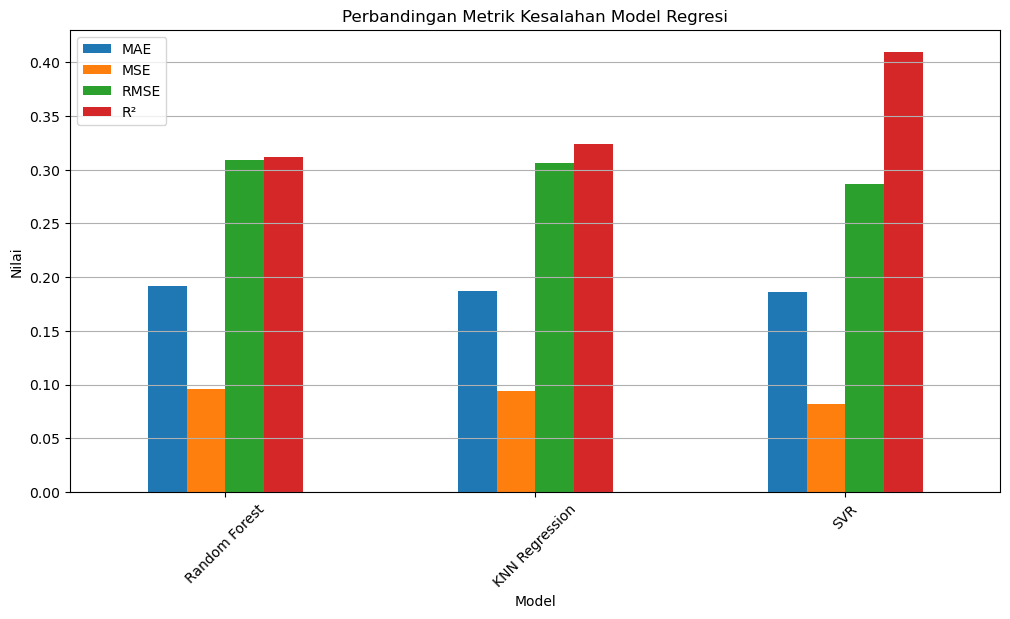

In [17]:

#Define the regression models
regression_models = []
regression_models.append(('Random Forest', RandomForestRegressor()))
regression_models.append(('KNN Regression', KNeighborsRegressor()))
regression_models.append(('SVR', SVR()))

# Evaluate each regression model
metrics = {
    'Model': [],
    'MAE': [],
    'MSE': [],
    'RMSE': [],
    'R²': []
}

for name, model in regression_models:
    model.fit(X_train_transformed, y_train) 
    y_pred_regression = model.predict(X_test_transformed)
    
    mae = mean_absolute_error(y_test, y_pred_regression)
    mse = mean_squared_error(y_test, y_pred_regression)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred_regression)
    
    # Store metrics
    metrics['Model'].append(name)
    metrics['MAE'].append(mae)
    metrics['MSE'].append(mse)
    metrics['RMSE'].append(rmse)
    metrics['R²'].append(r2)
    
# Create DataFrame from metrics
metrics_df_regression = pd.DataFrame(metrics)

print(metrics_df_regression)

# Plot Bar for Error Metrics
metrics_df_regression.set_index('Model').plot(kind='bar', figsize=(12, 6))
plt.title('Perbandingan Metrik Kesalahan Model Regresi')
plt.ylabel('Nilai')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# Hyperparameter

In [18]:
# Setelah preprocessing dan pemisahan fitur dan target
# Separate features and target
x = df.drop('Output', axis=1)
y = df['Output']

# Split into train and validation sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

# Define the models and their hyperparameters
models = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    }
}

# Store results
results = []

# Evaluate each model with cross-validation and hyperparameter tuning
for name, model_info in models.items():
    model = model_info['model']
    params = model_info['params']
    
    # Use GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(model, params, cv=StratifiedKFold(n_splits=10), scoring='accuracy', n_jobs=-1)
    
    # Fit the model
    grid_search.fit(X_train_transformed, y_train)
    
    # Get the best model
    best_model = grid_search.best_estimator_
    
    # Store results
    results.append({
        'Model': name,
        'Best Params': grid_search.best_params_
    })

# Create a DataFrame to hold the results
results_df = pd.DataFrame(results)

# Display results
print(results_df)




           Model                                        Best Params
0            KNN          {'n_neighbors': 7, 'weights': 'distance'}
1  Random Forest  {'max_depth': None, 'min_samples_split': 2, 'n...
2            SVM                     {'C': 0.1, 'kernel': 'linear'}


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Load data and process
df = pd.read_csv('onlinefoods.csv')
df = df.drop('Unnamed: 12', axis=1)  #
# Assuming df is your DataFrame
categorical_features = ['Gender', 'Marital Status', 'Occupation', 'Monthly Income','Educational Qualifications','Feedback']
numerical_features = ['Age', 'Family size','latitude','longitude','Pin code']

# Create LabelEncoders for each categorical feature
label_encoders = {}
for column in categorical_features:
    if df[column].dtype == 'object' or df[column].dtype.name == 'category':
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

# Define ColumnTransformer
ct = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# Separate features and target
x = df.drop('Output', axis=1)
y = df['Output']

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

# Apply transformations
X_train_transformed = ct.fit_transform(x_train)
X_test_transformed = ct.transform(x_test)

# Define and train the model
model = RandomForestClassifier()
model.fit(X_train_transformed, y_train)

# Save the model and transformer
with open('best_model.pkl', 'wb') as file:
    joblib.dump(model, file)

with open('preprocessor.pkl', 'wb') as file:
    joblib.dump(ct, file)
